In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import os
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    '''
    Level of similarity of two images
    Dice Coeff = 2*|A∩B|/(|A|+|B|)
    Between 0
    '''
    y_pred = (y_pred > 0.5)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

'''def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)'''


In [31]:
def unet_model(input_size=(256, 256, 1)):
    '''
    4 encoder, 4 decoder layers, 1 bottleneck layer
    Output: softmax-probabilities for each pixel to be a tumor
    We set a threshold for the output
    '''
    inputs = Input(input_size)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

In [32]:
def load_data():
    data_path = "/content/drive/MyDrive/Colab Notebooks/InteractiveML/data"
    x_all = []
    y_all = []

    imgs_folder = os.path.join(data_path, "patients", "imgs")
    labels_folder = os.path.join(data_path, "patients", "labels")

    for img_name in sorted(os.listdir(imgs_folder)):
        img_path = os.path.join(imgs_folder, img_name)
        img = image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
        img_array = image.img_to_array(img) / 255.0
        x_all.append(img_array)

    imgs_folder = os.path.join(data_path, "controls", "imgs")

    for img_name in sorted(os.listdir(imgs_folder)):
        img_path = os.path.join(imgs_folder, img_name)
        img = image.load_img(img_path, target_size=(256, 256), color_mode='grayscale')
        img_array = image.img_to_array(img) / 255.0
        x_all.append(img_array)

    for img_name in sorted(os.listdir(labels_folder)):
        label_path = os.path.join(labels_folder, img_name)
        label_img = image.load_img(label_path, target_size=(256, 256), color_mode='grayscale')
        label_array = image.img_to_array(label_img) / 255.0
        y_all.append(label_array)

    x_all = np.array(x_all)
    y_all = np.array(y_all)

    x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.1, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

    return x_train, y_train, x_test, y_test, x_val, y_val

In [50]:
def train_model(x_train, y_train, x_val, y_val):
    '''
    Optimizer: Adam
    Loss: Dice Loss
    Metrics: Dice Coefficient
    Reguralization: Early Stopping
    Learning Rate: 1e-4
    Epochs: 50
    Batch size: 8
    '''
    model = unet_model()

    model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=[dice_coefficient])

    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=8,
        validation_data=(x_val, y_val),
        verbose=1,
        callbacks=[early_stopping]
    )

    model.save_weights('/content/drive/MyDrive/Colab Notebooks/InteractiveML/model.weights.h5')

    return model

In [34]:
x_train, y_train, x_test, y_test, x_val, y_val = load_data()

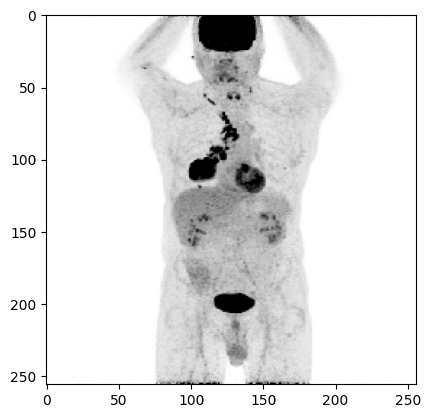

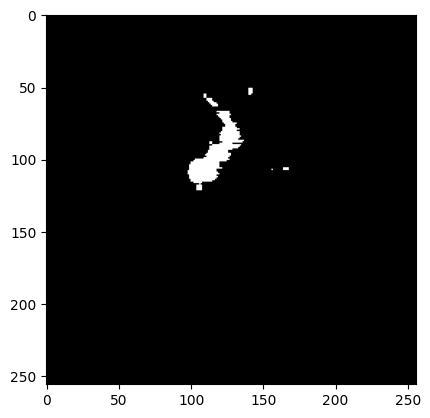

In [35]:
plt.figure()
plt.imshow(x_train[13], cmap='gray')
plt.show()
plt.figure()
plt.imshow(y_train[13], cmap='gray')
plt.show()

In [51]:
model = train_model(x_train, y_train, x_val, y_val)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_171 (Conv2D)       │ (None, 256, 256, 64)   │            640 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_172 (Conv2D)       │ (None, 256, 256, 64)   │         36,928 │ conv2d_171[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_36          │ (None, 128, 128, 64)   │              0 │ conv2d_172[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_173 (Conv2D)       │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_36[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_174 (Conv2D)       │ (None, 128, 128, 128)  │        147,584 │ conv2d_173[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_37          │ (None, 64, 64, 128)    │              0 │ conv2d_174[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_175 (Conv2D)       │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_37[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_176 (Conv2D)       │ (None, 64, 64, 256)    │        590,080 │ conv2d_175[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_38          │ (None, 32, 32, 256)    │              0 │ conv2d_176[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_177 (Conv2D)       │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_38[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_178 (Conv2D)       │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_177[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_39          │ (None, 16, 16, 512)    │              0 │ conv2d_178[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_179 (Conv2D)       │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_39[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_180 (Conv2D)       │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_179[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_36       │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_180[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_36       

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 46s 529ms/step - dice_coefficient: 0.0307 - loss: 0.3413 - val_dice_coefficient: 6.0336e-10 - val_loss: 0.0340
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 429ms/step - dice_coefficient: 0.0816 - loss: 0.0191 - val_dice_coefficient: 6.0336e-10 - val_loss: 0.0305
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 426ms/step - dice_coefficient: 0.0492 - loss: 0.0171 - val_dice_coefficient: 6.0336e-10 - val_loss: 0.0241
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 433ms/step - dice_coefficient: 0.0425 - loss: 0.0135 - val_dice_coefficient: 6.0336e-10 - val_loss: 0.0214
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - dice_coefficient: 0.0628 - loss: 0.0116 - val_dice_coefficient: 6.0336e-10 - val_loss: 0.0233
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 432ms/step - dice_coefficient: 0.0537 - loss: 0.0116 - val_dice_coefficient: 6.0336e-10 - val_loss: 0.0191
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 441ms/step - dice_coefficient: 0.0713 - loss: 0.0103 - val_dice_

In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import save_img

model1 = unet_model()

model1.load_weights('/content/drive/MyDrive/Colab Notebooks/InteractiveML/model.weights.h5')


In [54]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import save_img

def test_model(model, x_test, y_test, threshold=0.5, save_path='/content/drive/MyDrive/Colab Notebooks/InteractiveML/predictions', num_images_to_plot=5):
    os.makedirs(save_path, exist_ok=True)

    predictions = model.predict(x_test)
    predictions = (predictions > threshold).astype(np.uint8)

    total_dice_coeff = 0.0
    num_images = len(x_test)

    for i in range(num_images):
        y_true = y_test[i]
        y_pred = predictions[i]

        dice_coeff = dice_coefficient(y_true, y_pred).numpy()
        total_dice_coeff += dice_coeff

        save_img(os.path.join(save_path, f'pred_{i}.png'), y_pred)

        if i < num_images_to_plot:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(y_true.squeeze(), cmap='gray')
            plt.title(f'Ground Truth {i+1}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(y_pred.squeeze(), cmap='gray')
            plt.title(f'Prediction {i+1}')
            plt.axis('off')

            plt.show()

    average_dice_coeff = total_dice_coeff / num_images

    return average_dice_coeff


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 476ms/step


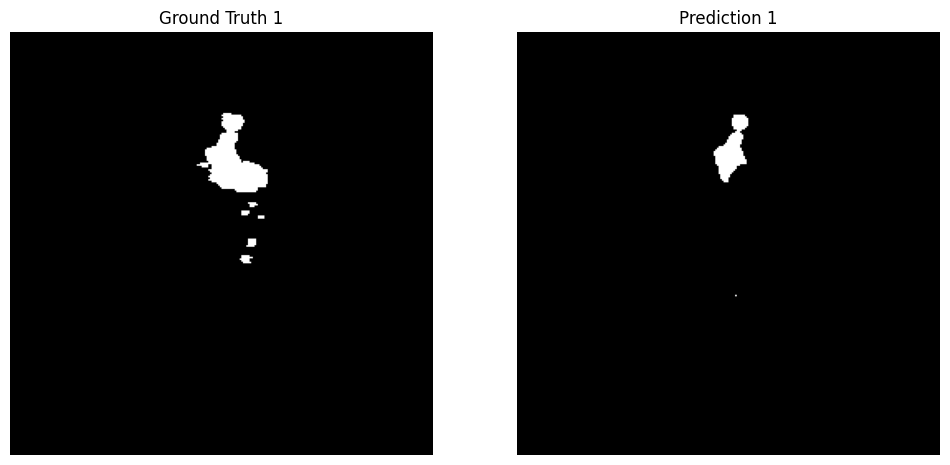

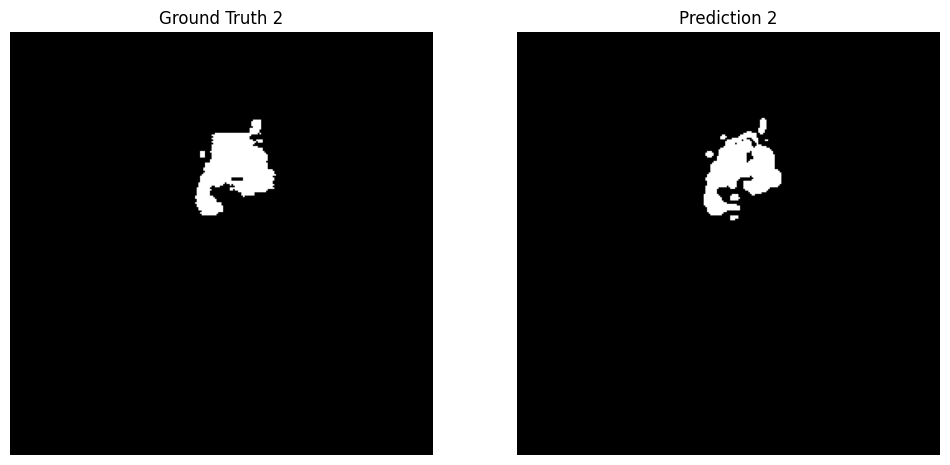

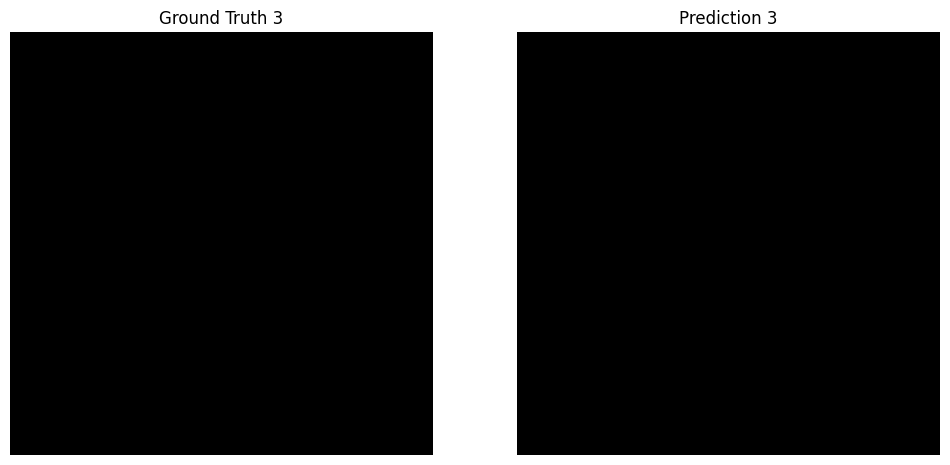

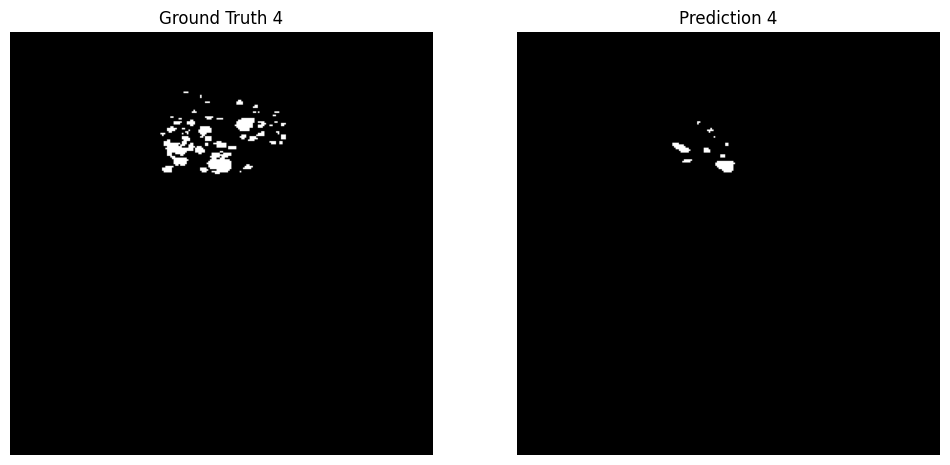

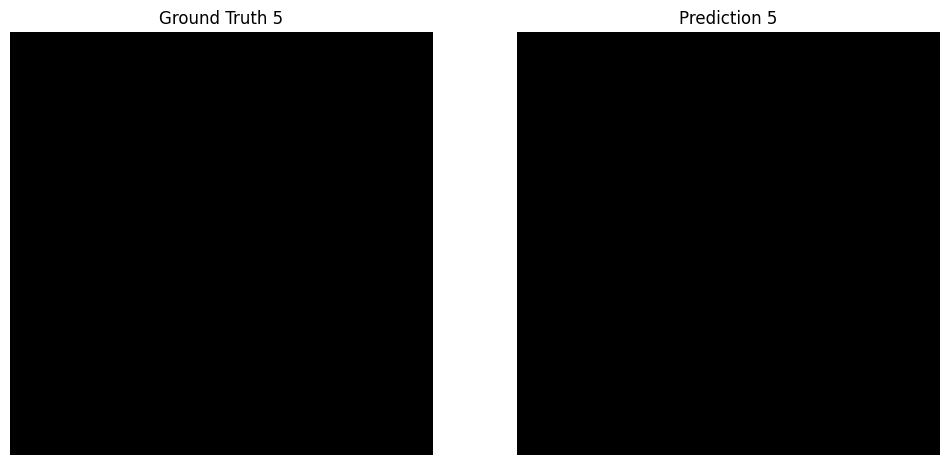

0.7941707070692938


In [62]:
average_dice_coeff = test_model(model1, x_test, y_test, threshold=0.8)
print(average_dice_coeff)